In [4]:
!pip install tqdm

In [5]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [6]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random
import numpy as np
import tqdm
import torch
import torch.nn as nn
from torch import optim

from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
import requests
from zipfile import ZipFile
from io import BytesIO

def download_and_unzip(url, extract_to='.'):
    """
    Downloads a ZIP file from the given URL and unzips it to the given directory.

    Parameters:
    url (str): The URL to download the ZIP file from.
    extract_to (str): The directory to extract the contents of the ZIP file to.
    """

    try:
        # Send a GET request to the URL
        print(f"Downloading file from {url}")
        response = requests.get(url)
        response.raise_for_status()

        # Extract all the contents of the zip file in the directory 'extract_to'
        with ZipFile(BytesIO(response.content)) as zip_file:
            print(f"Extracting contents to {extract_to}")
            zip_file.extractall(path=extract_to)
            print("Extraction completed.")
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred: {http_err}")  # Python 3.6
    except Exception as err:
        print(f"An error occurred: {err}")

download_and_unzip('https://download.pytorch.org/tutorial/data.zip', '.')

print('\nFirst 10 lines of the file:')
!head data/eng-fra.txt

Extracting contents to .
Extraction completed.

First 10 lines of the file:
Go.	Va !
Run!	Cours !
Run!	Courez !
Wow!	Ça alors !
Fire!	Au feu !
Help!	À l'aide !
Jump.	Saute.
Stop!	Ça suffit !
Stop!	Stop !
Stop!	Arrête-toi !


In [8]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicode2ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def preprocess_string(s):
    s = unicode2ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

MAX_LENGTH = 10
ENG_PREFIXES = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

# Filter pairs
def filter_pairs(pairs):
    subset = []
    for fr, en in pairs:
        if len(fr.split(' ')) > MAX_LENGTH:
            continue
        if len(en.split(' ')) > MAX_LENGTH:
            continue
        if not en.startswith(ENG_PREFIXES):
            continue
        subset.append((fr, en))
    return subset


# Read the data
def read_dataset(lang1, lang2, reverse=False):

    # Read the file and split into lines
    print("Reading lines...")
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    print("Processing lines...")
    pairs = [[preprocess_string(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]

    # Filter pairs by length and content
    pairs = filter_pairs(pairs)

    print("Finished processing")
    return pairs

corpus_pairs = read_dataset('eng', 'fra', reverse=True)

print(f"\nFound {len(corpus_pairs)} translation pairs.")
print("Here are 10 examples")
for _ in range(10):
    fr, en = random.choice(corpus_pairs)
    print(f"French: {fr} -> English: {en}")

Reading lines...
Processing lines...
Finished processing

Found 12038 translation pairs.
Here are 10 examples
French: tu es le seul a pouvoir faire ca -> English: you re the only one who can do this
French: vous etes tous seuls -> English: you re all alone
French: c est un jeune directeur plein de talent -> English: he s a talented young director
French: c est lui n est ce pas ? -> English: he s the one isn t he ?
French: ce n est pas un saint -> English: he s no saint
French: ils s amusent -> English: they re enjoying themselves
French: elle n est pas une enfant -> English: she s not a child
French: je suis la plus jeune enfant -> English: i m the youngest in the family
French: il est plus grand que moi -> English: he s taller than me
French: vous etes trop maigrichons -> English: you re too skinny


In [ ]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"PAD": 0, "SOS": 1, "EOS": 2, "UNK": 3}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS", 3: "UNK"}
        self.word2count = {}
        self.n_words = 4  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    def tokenize(self, sentence, seq_len=None):
        # Add Start Of Sentence token
        token_seq_idx = [self.word2index["SOS"]]

        # Tokenize each word in sentence
        for tkn in sentence.split():
            token_seq_idx.append(self.word2index[tkn if tkn in self.word2index else "UNK"])

        # Add End Of Sentence token
        token_seq_idx.append(self.word2index["EOS"])

        if seq_len is not None:
            if len(token_seq_idx) < seq_len:
                # Pad to desired lengh
                token_seq_idx += [self.word2index["PAD"]] * (seq_len - len(token_seq_idx))
            else:
                # Trim sentence to length
                token_seq_idx = token_seq_idx[:seq_len]

        return token_seq_idx

    def list2sentence(self, seq_ids):
        return " ".join([self.index2word[idx] for idx in seq_ids])
    def build_vocab(self, max_words=3000):
      # Sort words by frequency
      sorted_words = sorted(self.word2count.items(), key=lambda x: x[1], reverse=True)
      sorted_words = sorted_words[:max_words - 4]  # Account for PAD, SOS, EOS, UNK

      # Reset mappings except special tokens
      self.word2index = {"PAD": 0, "SOS": 1, "EOS": 2, "UNK": 3}
      self.index2word = {0: "PAD", 1: "SOS", 2: "EOS", 3: "UNK"}
      self.n_words = 4

      for word, _ in sorted_words:
          self.word2index[word] = self.n_words
          self.index2word[self.n_words] = word
          self.n_words += 1

print("Creating French and English dictionaries.")
fr_vocab = Lang('fr')
en_vocab = Lang('en')

# First pass: count words
for fr, en in corpus_pairs:
    fr_vocab.addSentence(fr)
    en_vocab.addSentence(en)

# Limit vocabulary
fr_vocab.build_vocab(max_words=3000)
en_vocab.build_vocab(max_words=3000)

print(f"French: {fr_vocab.n_words} words found.")
print(f"English: {en_vocab.n_words} words found.")


In [ ]:
def create_dataloaders(batch_size):
    # Create two huge tensor with all english and french sentences
    n = len(corpus_pairs)
    french_seqs_ids = torch.zeros((n, MAX_LENGTH+2)).long()
    english_seqs_ids = torch.zeros((n, MAX_LENGTH+2)).long()

    for idx, (fr, en) in enumerate(corpus_pairs):
        french_seqs_ids[idx] = torch.tensor(fr_vocab.tokenize(fr, seq_len=MAX_LENGTH+2))
        english_seqs_ids[idx] = torch.tensor(en_vocab.tokenize(en, seq_len=MAX_LENGTH+2))

    # Split into training and testing
    train_sample_mask = torch.rand((n,)) > 0.3
    train_french_seqs_ids = french_seqs_ids[train_sample_mask]
    train_english_seqs_ids = english_seqs_ids[train_sample_mask]
    test_french_seqs_ids = french_seqs_ids[~train_sample_mask]
    test_english_seqs_ids = english_seqs_ids[~train_sample_mask]

    # Create train dataloader
    train_data = TensorDataset(train_french_seqs_ids.to(device), train_english_seqs_ids.to(device))
    train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size)

    # Create test dataloader
    test_data = TensorDataset(test_french_seqs_ids.to(device), test_english_seqs_ids.to(device))
    # test_dataloader = DataLoader(test_data, sampler=RandomSampler(train_data), batch_size=batch_size)
    return train_dataloader, test_data

# Test the dataloader
train_dataloader, test_data = create_dataloaders(32)
for fr, en in train_dataloader:
    print('Batch | fr =', fr.shape, '| en =', en.shape)
    print('First sentence in French: ', fr_vocab.list2sentence(fr[0].tolist()))
    print('First sentence in English:', en_vocab.list2sentence(en[0].tolist()))
    break

Position Encodings: (Max Position, Embedding Size) = (2048, 512)


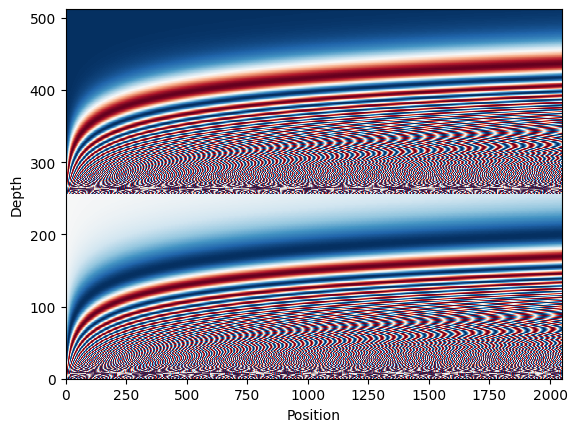

In [11]:
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1)

    return pos_encoding


pos_encoding = positional_encoding(length=2048, depth=512)

# Visualize Position Embeddings
import matplotlib.pyplot as plt
print("Position Encodings: (Max Position, Embedding Size) =", pos_encoding.shape)
plt.pcolormesh(pos_encoding.T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.show()

In [12]:
class WordPosEmbedding(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        nn.init.normal_(self.embedding.weight, mean=0, std=0.01)
        self.pos_encoding = torch.Tensor(positional_encoding(length=2048, depth=d_model)).float().to(device)
        self.pos_encoding.requires_grad = False

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def forward(self, x):
        length = x.shape[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= (self.d_model ** 0.5)
        x = x + self.pos_encoding[None, :length, :]
        return x

embed_fr = WordPosEmbedding(vocab_size=fr_vocab.n_words, d_model=512).to(device)
embed_en = WordPosEmbedding(vocab_size=en_vocab.n_words, d_model=512).to(device)

# Example usage: embed layer receives a batch of sequences of word indexes (ie, a matrix of size BxL where B is batch size and L sequence lenght)
en_sentence = 'i am awesome'
en_seq = torch.tensor([en_vocab.word2index[w] for w in en_sentence.split()]).unsqueeze(0)
print(en_seq.shape)
en_tkn_seq = embed_en(en_seq.to(device))
print(en_tkn_seq.shape)

fr_sentence = 'je plaisante'
fr_seq = torch.tensor([fr_vocab.word2index[w] for w in fr_sentence.split()]).unsqueeze(0)
print(fr_seq.shape)
fr_tkn_seq = embed_fr(fr_seq.to(device))
print(fr_tkn_seq.shape)

torch.Size([1, 3])
torch.Size([1, 3, 512])
torch.Size([1, 2])
torch.Size([1, 2, 512])


In [13]:
class AddNorm(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, res):
        return self.norm(x + res)

In [14]:
class CrossAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.):
        super().__init__()
        self.mha = nn.MultiheadAttention(d_model, num_heads, dropout=dropout, batch_first=True)
        self.add_norm = AddNorm(d_model)

    def forward(self, x, context):
        attn_output, attn_scores = self.mha.forward(
            query=x, key=context, value=context)
        x = self.add_norm(x, attn_output)

        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores
        return x

# Example usage
sample_ca = CrossAttention(d_model=512, num_heads=2).to(device)
print('Batch of English Sentences:', en_tkn_seq.shape)
print('Batch of French Sentences:', fr_tkn_seq.shape)
print('Output of Cross-Attention:', sample_ca(en_tkn_seq.to(device), fr_tkn_seq.to(device)).shape)

Batch of English Sentences: torch.Size([1, 3, 512])
Batch of French Sentences: torch.Size([1, 2, 512])
Output of Cross-Attention: torch.Size([1, 3, 512])


In [15]:
class GlobalSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.):
        super().__init__()
        self.mha = nn.MultiheadAttention(d_model, num_heads, dropout=dropout, batch_first=True)
        self.add_norm = AddNorm(d_model)

    def forward(self, x):
        attn_output, attn_scores = self.mha(
            query=x,
            key=x,
            value=x)
        x = self.add_norm(x, attn_output)

        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores
        return x


# Example usage
sample_gsa = GlobalSelfAttention(d_model=512, num_heads=2).to(device)
print('Batch of French Sentences:', fr_tkn_seq.shape)
print('Output of Global Self-Attention:', sample_gsa(fr_tkn_seq.to(device)).shape)

Batch of French Sentences: torch.Size([1, 2, 512])
Output of Global Self-Attention: torch.Size([1, 2, 512])


In [16]:
from torch.nn import Transformer as TF

class CausalSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.):
        super().__init__()
        self.mha = nn.MultiheadAttention(d_model, num_heads, dropout=dropout, batch_first=True)
        self.add_norm = AddNorm(d_model)

    def forward(self, x):
        causal_mask = TF.generate_square_subsequent_mask(x.shape[1], device=device)
        attn_output, attn_scores = self.mha(
            query=x,
            key=x,
            value=x,
            attn_mask=causal_mask)
        x = self.add_norm(x, attn_output)

        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores
        return x

# Example usage
sample_csa = CausalSelfAttention(d_model=512, num_heads=2).to(device)
print('Batch of English Sentences:', en_tkn_seq.shape)
print('Output of Causal Self-Attention:', sample_csa(en_tkn_seq.to(device)).shape)

Batch of English Sentences: torch.Size([1, 3, 512])
Output of Causal Self-Attention: torch.Size([1, 3, 512])


In [17]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout_rate=0.1):
        super().__init__()
        self.ffnet = nn.Sequential(
            nn.Linear(d_model, d_ff*d_model),
            nn.ReLU(inplace=True),
            nn.Linear(d_ff*d_model, d_model),
            nn.Dropout(dropout_rate)
        )
        self.add_norm = AddNorm(d_model)

    def forward(self, x):
        x = self.add_norm(x, self.ffnet(x))
        return x

# Example usage
sample_ffnet = FeedForward(d_model=512, d_ff=4).to(device)
print('Batch of English Sentences:', en_tkn_seq.shape)
print('Output of Causal Self-Attention:', sample_ffnet(en_tkn_seq.to(device)).shape)

Batch of English Sentences: torch.Size([1, 3, 512])
Output of Causal Self-Attention: torch.Size([1, 3, 512])


In [18]:
class EncoderLayer(nn.Module):
    def __init__(self,d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.self_attention = GlobalSelfAttention(
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout_rate)
        self.ffn = FeedForward(d_model, dff)

    def forward(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x


class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads,
                 dff, vocab_size, dropout_rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = WordPosEmbedding(
            vocab_size=vocab_size, d_model=d_model)

        self.enc_layers = nn.ModuleList([
            EncoderLayer(d_model=d_model,
                         num_heads=num_heads,
                         dff=dff,
                         dropout_rate=dropout_rate)
            for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # `x` is token-IDs shape: (batch, seq_len)
        x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

        # Add dropout.
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`.


# Example usage
encoder = Encoder(num_layers=3, d_model=512, num_heads=8, dff=4, vocab_size=fr_vocab.n_words).to(device)
print('Batch of English Sentences:', fr_seq.shape)
print('Output of Causal Self-Attention:', encoder(fr_seq.to(device)).shape)

Batch of English Sentences: torch.Size([1, 2])
Output of Causal Self-Attention: torch.Size([1, 2, 512])


In [19]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.causal_self_attention = CausalSelfAttention(
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout_rate)

        self.cross_attention = CrossAttention(
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def forward(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)
        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.

        # Cache the last attention scores for plotting later
        self.last_attn_scores = self.cross_attention.last_attn_scores

        return x


class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, dff, vocab_size,
                 dropout_rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = WordPosEmbedding(vocab_size=vocab_size,
                                              d_model=d_model)
        self.dropout = nn.Dropout(dropout_rate)
        self.dec_layers = nn.ModuleList([
            DecoderLayer(d_model=d_model, num_heads=num_heads,
                         dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)])

        self.last_attn_scores = None

    def forward(self, x, context):
        # `x` is token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)
        x = self.dropout(x)

        for i in range(self.num_layers):
            x  = self.dec_layers[i](x, context)

        self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        # The shape of x is (batch_size, target_seq_len, d_model).
        return x


# Example usage
decoder = Decoder(num_layers=3, d_model=512, num_heads=8, dff=4, vocab_size=fr_vocab.n_words).to(device)
print('Batch of French Sentences:', fr_seq.shape)
print('Batch of English Sentences:', en_seq.shape)
fr_feats = encoder(fr_seq.to(device))
tgt_feats = decoder(en_seq.to(device), fr_feats)
print('Output of Causal Self-Attention:', tgt_feats.shape)

Batch of French Sentences: torch.Size([1, 2])
Batch of English Sentences: torch.Size([1, 3])
Output of Causal Self-Attention: torch.Size([1, 3, 512])


In [20]:
class Transformer(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, dff,
                 input_vocab_size, target_vocab_size, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=input_vocab_size,
                               dropout_rate=dropout_rate)

        self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=target_vocab_size,
                               dropout_rate=dropout_rate)

        self.final_layer = nn.Linear(d_model, target_vocab_size)

    def forward(self, x, context):
        # Extracts global representations from the context sequence
        context = self.encoder(context)  # (batch_size, context_len, d_model)

        # Processes the predictions using a causal decoder.
        x = self.decoder(x, context)  # (batch_size, target_len, d_model)

        # Predicts the next token using a final linear layer classifier.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        return logits

# Example usage
transformer = Transformer(num_layers=3, d_model=512, num_heads=8, dff=4,
                          input_vocab_size=fr_vocab.n_words,
                          target_vocab_size=en_vocab.n_words).to(device)
print('Batch of French Sentences:', fr_seq.shape)
print('Batch of English Sentences:', en_seq.shape)
print('Output of Causal Self-Attention:', transformer(fr_seq.to(device), en_seq.to(device)).shape)

Batch of French Sentences: torch.Size([1, 2])
Batch of English Sentences: torch.Size([1, 3])
Output of Causal Self-Attention: torch.Size([1, 2, 3111])


## Evaluation

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there.

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements.


In [21]:
@torch.no_grad()
def evaluate(transformer, en_sentence):
    transformer.eval()
    with torch.no_grad():
        # The French sentence is tokenized and converted to a batch of B=1
        english_tkns = torch.tensor(en_vocab.tokenize(en_sentence)).long().unsqueeze(0).to(device)

        # First, the sentence to be translated is encoded using the transformer encoder.
        english_feats = transformer.encoder(english_tkns)

        # The translation sentence is initialized with SOS token
        decoded_tkns = torch.tensor([[fr_vocab.word2index['SOS']]]).long().to(device)

        # We'll keep track of the predicted logits in order to compute the perplexity
        pred_logits = []

        # Then, we evaluate the decoder, to generate the next words in the translation, one word at a time.
        for i in range(MAX_LENGTH-1):
            next_pred_feat = transformer.decoder(decoded_tkns, english_feats)[:, -1]
            next_pred_logit = transformer.final_layer(next_pred_feat)
            next_pred = next_pred_logit.argmax(dim=1, keepdims=True)
            pred_logits.append(next_pred_logit)
            if next_pred.item() == fr_vocab.word2index['EOS']:
                break
            decoded_tkns = torch.cat((decoded_tkns, next_pred), dim=1)

        decoded_tkns = decoded_tkns.squeeze(0) # squeeze batch dimension
        translation_words = fr_vocab.list2sentence(decoded_tkns[1:].tolist())
        pred_logits = torch.cat(pred_logits, 0)
    return translation_words, decoded_tkns, pred_logits

@torch.no_grad()
def evaluate_one_epoch(transformer, n=100):
    transformer.eval()
    criterion = nn.CrossEntropyLoss()
    loss, perplexity = 0., 0.
    for i in tqdm.tqdm(range(n), desc='[EVAL]'):
        fr_tkns, en_tkns = random.choice(test_data)
        en = en_vocab.list2sentence(en_tkns[en_tkns > 2].tolist())
        _, _, pred_logits = evaluate(transformer, en)
        l = criterion(pred_logits, en_tkns[1:1+len(pred_logits)]).item()
        loss += l
        perplexity += np.exp(l)
    return loss / n, perplexity / n

@torch.no_grad()
def translate_randomly(transformer, n=3):
    for i in range(n):
        fr_tkn, en_tkn = random.choice(test_data)
        en = en_vocab.list2sentence(en_tkn[en_tkn > 2].tolist())
        fr = fr_vocab.list2sentence(fr_tkn[fr_tkn > 2].tolist())
        print('>', fr)
        print('=', en)
        output_sentence, _, _ = evaluate(transformer, en)
        print('<', output_sentence)
        print('')

translate_randomly(transformer)
loss, perplexity = evaluate_one_epoch(transformer)
print('Loss = ', loss)
print('Perplexity = ', perplexity)

> tu es l elu
= you are the chosen one
< suivent suivent deprimes deprimes distraite distraite distraite distraite distraite

> je suis mal barre
= i am in trouble
< suivent deprimes deprimes deprimes siderees siderees siderees siderees siderees

> nous n allons pas accoster
= we re not going ashore
< suivent deprimes deprimes deprimes distraite distraite distraite distraite distraite



[EVAL]: 100%|██████████| 100/100 [00:03<00:00, 26.50it/s]

Loss =  8.222987661361694
Perplexity =  3766.5898814386837


# Training

To train, we use our typical training loop to optimize all weights of the model by gradient descent.
The transformer model receives as input batches of French and English sentence pairs. The encoder processes the French sentence globally, and the decoder processes the English sentence causally (only looking at previous tokens) while simultaneously attending to the encoder output.
The transformer finally outputs a prediction if the next word, at each point in the translation.
The model is trained to optimize the CrossEntropy loss (over the English dictionary) using the Adam optimizer.

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import tqdm


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


def train_epoch(dataloader, transformer, optimizer, criterion):
    transformer.train()

    total_loss = 0
    for fr_tensor, en_tensor in dataloader:
        fr_past = fr_tensor[:, :-1]
        fr_target = fr_tensor[:, 1:]
        # print(en_past.shape, en_target.shape, fr_tensor.shape)

        preds = transformer(fr_past, en_tensor)
        # print(preds.shape)

        loss = criterion(
            preds.flatten(0, 1),
            fr_target.flatten(0, 1)
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def train(train_dataloader, transformer, optimizer, n_epochs,
          print_every=5, plot_every=1):
    plot_losses = []

    criterion = nn.CrossEntropyLoss()

    for epoch in tqdm.tqdm(range(n_epochs), desc='[TRAIN]'):
        loss = train_epoch(train_dataloader, transformer, optimizer, criterion)

        if epoch % print_every == 0:
            te_loss, te_perplexity = evaluate_one_epoch(transformer)
            print(f'[Epoch={epoch}/{n_epochs}] Training Loss={loss:.4f}. Test Loss = {te_loss:.4f}. Test Perplexity = {te_perplexity:.2f}')
            translate_randomly(transformer, n=3)

        if epoch % plot_every == 0:
            plot_losses.append(loss)

    showPlot(plot_losses)


[TRAIN]:   3%|▎         | 1/30 [00:05<02:39,  5.52s/it]

[Epoch=0/30] Training Loss=2.9964. Test Loss = 8.2186. Test Perplexity = 7181.03
> tu n es pas autorise a penetrer ici
= you re not allowed in here
< je suis desolee je suis pas ?

> vous etes la personne la plus paresseuse que je connaisse
= you re the laziest person i know
< je suis desolee je suis pas ?

> je suis tres fatiguee par le dur labeur
= i am very tired from the hard work
< je suis desolee je suis pas ?



[TRAIN]:  20%|██        | 6/30 [00:15<01:03,  2.64s/it]

[Epoch=5/30] Training Loss=0.7275. Test Loss = 10.3090. Test Perplexity = 97740.05
> je suis a toi et tu es a moi
= i am yours and you are mine
< je suis votre et vous etes miennes

> je ne suis pas fou
= i m not crazy
< je ne suis pas fou

> je suis a votre merci
= i m at your mercy
< je suis a votre je suis votre opinion



[TRAIN]:  37%|███▋      | 11/30 [00:25<00:44,  2.34s/it]

[Epoch=10/30] Training Loss=0.4316. Test Loss = 10.9844. Test Perplexity = 211354.56
> je ne suis pas autorise a t aider
= i m not allowed to help you
< je ne suis pas autorise a vous aider

> ils forment le dessus du panier
= they re the cream of the crop
< ils forment le dessus du panier

> tu dois faire comme je te dis
= you are to do as i tell you
< tu fais aussi faire comme je te dire



[TRAIN]:  53%|█████▎    | 16/30 [00:35<00:32,  2.31s/it]

[Epoch=15/30] Training Loss=0.3332. Test Loss = 11.5160. Test Perplexity = 257695.82
> il est toujours en train de rire
= he is always laughing
< il est toujours en train de gagner du monde

> je ne suis pas sure qu il l ait vue
= i m not sure if he saw it
< je ne suis pas sur qu il l ait

> je me fais du souci pour elles
= i m worried about them
< je me fais du souci pour eux qui j



[TRAIN]:  70%|███████   | 21/30 [00:45<00:20,  2.27s/it]

[Epoch=20/30] Training Loss=0.2857. Test Loss = 11.6105. Test Perplexity = 619151.70
> nous retournons a boston
= we re going back to boston
< nous allons de boston de boston

> je suis tres en faveur de cela
= i m very much in favor of this
< je suis tres en faveur de cela

> je me sens plutot fatigue
= i m feeling sort of tired
< je me sens plutot fatigue



[TRAIN]:  87%|████████▋ | 26/30 [00:55<00:09,  2.47s/it]

[Epoch=25/30] Training Loss=0.2518. Test Loss = 12.2666. Test Perplexity = 1097493.19
> qu on ne me derange pas !
= i m not to be disturbed
< je ne vais pas derange derange

> il est a la maison aujourd hui
= he is at home today
< il est a la maison aujourd hui

> c est une femme magnifique
= she is a wonderful woman
< c est une femme magnifique



[TRAIN]: 100%|██████████| 30/30 [01:01<00:00,  2.05s/it]


<Figure size 640x480 with 0 Axes>

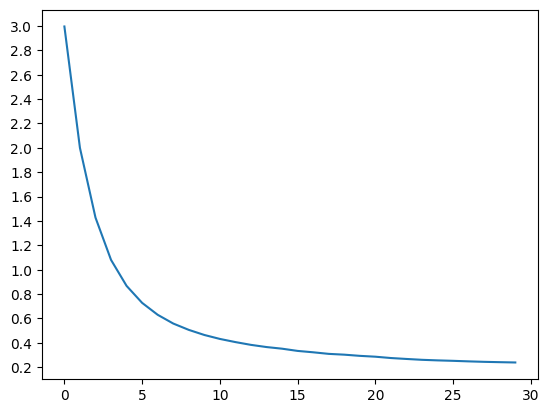

In [23]:
epochs = 30
batch_size = 128
num_layers = 2
learning_rate = 0.001
weight_decay = 0.0005

train_dataloader, test_dataloader = create_dataloaders(batch_size)

transformer = Transformer(num_layers=num_layers, d_model=256, num_heads=8, dff=4,
                          input_vocab_size=en_vocab.n_words,
                          target_vocab_size=fr_vocab.n_words).to(device)

optimizer = optim.Adam(transformer.parameters(), lr=learning_rate, weight_decay=weight_decay)

train(train_dataloader, transformer, optimizer, epochs)

In [ ]:
# B
epochs = 30
batch_size = 128
num_layers = 4
learning_rate = 0.001
weight_decay = 0.0005

train_dataloader, test_dataloader = create_dataloaders(batch_size)

transformer = Transformer(num_layers=num_layers, d_model=1024, num_heads=8, dff=4,
                          input_vocab_size=en_vocab.n_words,
                          target_vocab_size=fr_vocab.n_words).to(device)

optimizer = optim.Adam(transformer.parameters(), lr=learning_rate, weight_decay=weight_decay)

train(train_dataloader, transformer, optimizer, epochs)

[TRAIN]:   3%|▎         | 1/30 [00:28<13:32, 28.02s/it]

[Epoch=0/30] Training Loss=4.3005. Test Loss = 6.6822. Test Perplexity = 4072.51
> je ne suis pas convaincu
= i m not persuaded
< PAD PAD PAD PAD PAD PAD PAD PAD PAD

> je vais a l hopital
= i m going to the hospital
< PAD PAD PAD PAD PAD PAD PAD PAD PAD

> c est moi meme qui ai cueilli ces fleurs
= i m the one who picked those flowers
< PAD PAD PAD PAD PAD PAD PAD PAD PAD



[TRAIN]:  20%|██        | 6/30 [02:30<10:12, 25.50s/it]

[Epoch=5/30] Training Loss=3.9376. Test Loss = 6.2641. Test Perplexity = 2880.36
> je suis ici pour voir le gerant
= i m here to see the manager
< PAD PAD PAD PAD PAD PAD PAD PAD PAD

> elle est forte
= she is strong
< PAD PAD PAD PAD PAD PAD PAD PAD PAD

> nous sommes a court d argent
= we are short of money
< PAD PAD PAD PAD PAD PAD PAD PAD PAD



[TRAIN]:  37%|███▋      | 11/30 [04:32<08:01, 25.36s/it]

[Epoch=10/30] Training Loss=3.0618. Test Loss = 13.0737. Test Perplexity = 875677.12
> vous etes deloyaux
= you re disloyal
< je je je je je je je je je

> vous etes si mechante
= you re so mean
< je je je je je je je je je

> il se sent beaucoup mieux
= he s feeling much better
< je je je je je je je je je



[TRAIN]:  53%|█████▎    | 16/30 [06:36<05:59, 25.66s/it]

[Epoch=15/30] Training Loss=2.1174. Test Loss = 11.0283. Test Perplexity = 137636.78
> tu es dans l erreur
= you re wrong
< je suis desolee je ne vous ai pas ?

> elles sont cousines
= they re cousins
< je suis desolee je ne vous ai pas ?

> elles sont nos invitees
= they are our guests
< je suis desolee je ne vous ai pas ?



[TRAIN]:  70%|███████   | 21/30 [08:40<03:51, 25.74s/it]

[Epoch=20/30] Training Loss=1.7946. Test Loss = 10.2555. Test Perplexity = 57778.03
> elle est photographe professionnelle
= she s a professional photographer
< je suis desole de vous avoir ete blesse

> je compte sur ton aide
= i m counting on your help
< je suis desole de vous avoir ete blesse

> il est negligent pour ce qui concerne l argent
= he is careless about money
< je suis desole de vous avoir ete blesse



[TRAIN]:  87%|████████▋ | 26/30 [10:43<01:41, 25.41s/it]

[Epoch=25/30] Training Loss=1.2517. Test Loss = 11.1345. Test Perplexity = 293905.82
> elle a peur des chiens
= she s scared of dogs
< elle est en train de se preparer le temps

> vous n etes pas chanteur
= you re no singer
< tu n es pas la

> il est tres seduisant
= he is very good looking
< il est tres bon en anglais



[TRAIN]:  90%|█████████ | 27/30 [11:06<01:14, 24.86s/it]

In [ ]:
# C
epochs = 30
batch_size = 128
num_layers = 4
learning_rate = 0.001
weight_decay = 0.0005

train_dataloader, test_dataloader = create_dataloaders(batch_size)

transformer = Transformer(num_layers=num_layers, d_model=1024, num_heads=8, dff=4,
                          input_vocab_size=en_vocab.n_words,
                          target_vocab_size=fr_vocab.n_words).to(device)

optimizer = optim.Adam(transformer.parameters(), lr=learning_rate, weight_decay=weight_decay)

train(train_dataloader, transformer, optimizer, epochs)

### Visualizing Attention

A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

You could simply run ``plt.matshow(attentions)`` to see attention output
displayed as a matrix. For a better viewing experience we will do the
extra work of adding axes and labels:




input = il n est pas aussi grand que son pere
output = il est obsede par des experiences de couteaux de


<ipython-input-24-117c288cf561>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-24-117c288cf561>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


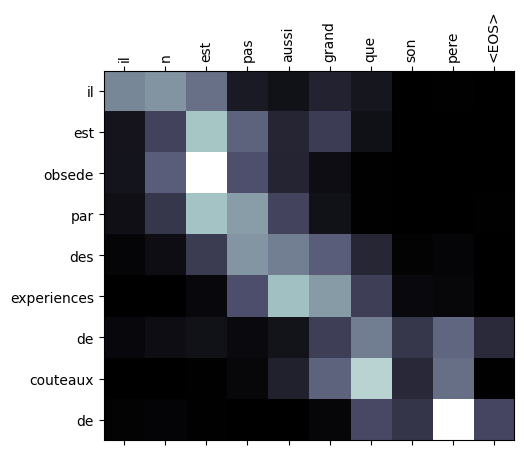

input = je suis trop fatigue pour conduire
output = il est suspecte de lancer de sa faiblesse


<ipython-input-24-117c288cf561>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-24-117c288cf561>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


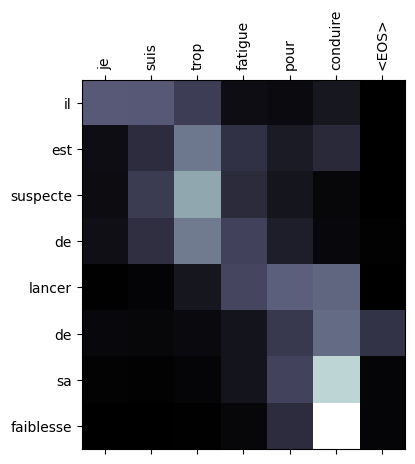

input = je suis desole si c est une question idiote
output = il est obsede par des experiences de couteaux de


<ipython-input-24-117c288cf561>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-24-117c288cf561>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


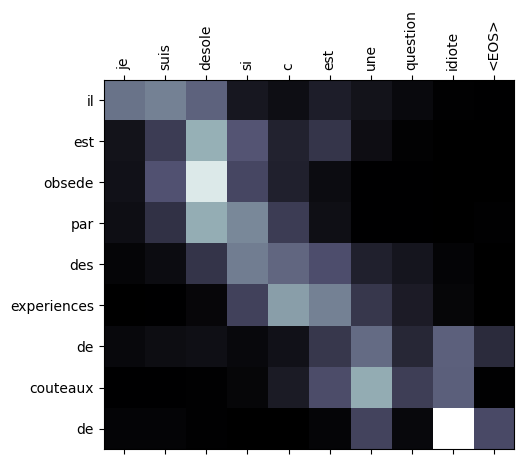

input = je suis reellement fiere de vous
output = il est suspecte de lancer de sa faiblesse


<ipython-input-24-117c288cf561>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-24-117c288cf561>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


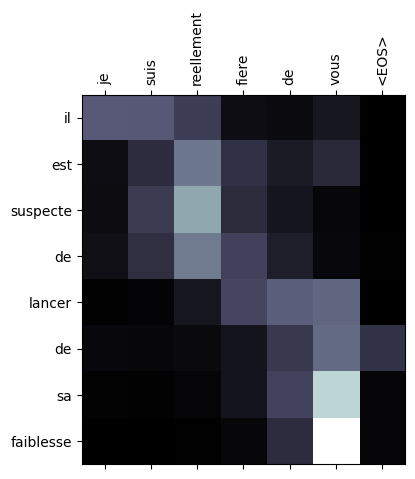

In [24]:
%matplotlib inline
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.matshow(attentions.cpu().numpy(), cmap='bone')

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_sentence, _, _ = evaluate(transformer, input_sentence)
    attention_scores = transformer.decoder.last_attn_scores
    print("="*30)
    print('input =', input_sentence)
    print('output =', output_sentence)
    showAttention(input_sentence, output_sentence.split(), attention_scores[0, :len(output_sentence.split()), 1:])


evaluateAndShowAttention('il n est pas aussi grand que son pere')

evaluateAndShowAttention('je suis trop fatigue pour conduire')

evaluateAndShowAttention('je suis desole si c est une question idiote')

evaluateAndShowAttention('je suis reellement fiere de vous')

In [25]:
fr_vocab.list2sentence(fr_vocab.tokenize("il n est pas aussi grand que son pere"))

'SOS il n est pas aussi grand que son pere EOS'